# Prédiction de réponses à une campagne marketing

#### Contexte
Une entreprise de e-commerce cherche à optimiser ses campagnes marketing en ciblant les clients les plus susceptibles d’y répondre.

#### Objectif
Développer un modèle permettant de prédire si un client répondra positivement à une campagne marketing à partir de ses comportements d’achat et ses données socio-démographiques.

## 1. Compréhension métier, définition du besoin

### Compréhension du besoin : 

À partir des données dont nous disposons (âge, sexe, revenu annuel, temps passé sur site, achats en ligne) ; essayer de déterminer si un ou plusieurs facteurs permettendt de pouvoir prédire, avec un certain taux de certitude, le fait qu'une personne répondra positivement ou non à la campagne. 


Mesures (métier) : taux de réponse (qu'elle soit positifve - 1 ou non - 0) à la campagne marketing

Métriques (technique) : F1-Score

#### Explication du choix de la métrique : 

F1-Score comme métrique à surveiller/optimiser.

Dans ce projet, l’objectif est de prédire si un individu va répondre positivement à une campagne marketing.
Le budget de contact est limité, et chaque contact inutile représente un coût (temps, image, argent).

Notre but est donc à la fois d'éviter :

Les faux positifs (cibler quelqu’un qui ne répondra pas)

Les faux négatifs (rater une personne qui aurait répondu).

La F1-Score nous permet de trouver un équilibre entre la précision et le recall.

## 2.1 et 2.2 Compréhension de la donnée (types de données, visualisations) et nettoyage si nécessaire

In [1016]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,  confusion_matrix, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mpl_toolkits.mplot3d import Axes3D

In [973]:
response_df = pd.read_csv("Dataset_Reponse_Marketing.csv")

In [974]:
response_df

,Age,Sexe,Revenu_annuel,Temps_passe_sur_site,Achats_en_ligne,Reponse_campagne
0,22,Homme,40124,16.518974,9,1
1,32,Femme,26307,21.973535,8,1
2,28,Femme,30040,26.762915,9,1
3,16,Femme,15843,29.046008,9,0
4,45,Homme,20225,21.479944,5,0
...,...,...,...,...,...,...
2395,26,Homme,34373,31.567494,10,1
2396,37,Femme,36249,26.347662,10,1
2397,30,Femme,34293,18.275369,7,0
2398,35,Homme,29447,17.211780,6,1


In [975]:
print(response_df.isnull().sum())

Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64


In [976]:
print((response_df == "?").sum())
print((response_df == "NA").sum())
print((response_df == "None").sum())

Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64
Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64
Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64


In [977]:
def detecter_aberrants_iqr(df, colonnes=None):
    """Détecte les valeurs aberrantes avec la méthode IQR"""
    if colonnes is None:
        colonnes = df.select_dtypes(include=[np.number]).columns
    
    aberrants_indices = set()
    rapport = {}
    
    for col in colonnes:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Seuils d'aberration
        borne_inf = Q1 - 1.5 * IQR
        borne_sup = Q3 + 1.5 * IQR
        
        # Identifier les aberrants
        aberrants_col = df[(df[col] < borne_inf) | (df[col] > borne_sup)].index
        aberrants_indices.update(aberrants_col)
        
        # Rapport
        nb_aberrants = len(aberrants_col)
        rapport[col] = {
            'nb_aberrants': nb_aberrants,
            'pct_aberrants': nb_aberrants / len(df) * 100,
            'borne_inf': borne_inf,
            'borne_sup': borne_sup,
            'valeurs_aberrantes': df.loc[aberrants_col, col].tolist()
        }
        
        print(f"\n=== {col} ===")
        print(f"Bornes normales: [{borne_inf:.2f}, {borne_sup:.2f}]")
        print(f"Aberrants: {nb_aberrants} ({nb_aberrants/len(df)*100:.1f}%)")
        if nb_aberrants > 0:
            print(f"Valeurs: {sorted(df.loc[aberrants_col, col].tolist())}")
    
    return list(aberrants_indices), rapport

# Utilisation sur votre DataFrame original
print("=== DÉTECTION DES VALEURS ABERRANTES ===")
indices_aberrants, rapport = detecter_aberrants_iqr(response_df)

print(f"\n=== RÉSUMÉ ===")
print(f"Total clients avec au moins une valeur aberrante: {len(indices_aberrants)}")
print(f"Pourcentage: {len(indices_aberrants)/len(response_df)*100:.1f}%")

=== DÉTECTION DES VALEURS ABERRANTES ===

=== Age ===
Bornes normales: [7.00, 63.00]
Aberrants: 13 (0.5%)
Valeurs: [-1, 1, 1, 2, 4, 5, 5, 6, 6, 6, 6, 66, 79]

=== Revenu_annuel ===
Bornes normales: [7171.75, 45151.75]
Aberrants: 18 (0.8%)
Valeurs: [4422, 5044, 5221, 5323, 5617, 6258, 6294, 6519, 7047, 45898, 46616, 46786, 47284, 47676, 48306, 48988, 49000, 50002]

=== Temps_passe_sur_site ===
Bornes normales: [11.26, 32.92]
Aberrants: 17 (0.7%)
Valeurs: [8.656393802123615, 9.957909934745931, 10.018932436801537, 10.095870103961902, 10.968585481810528, 10.974148811637155, 11.034042282090493, 32.97245148985498, 33.28800099935359, 33.38803835583056, 33.56257196159655, 33.752752268623084, 33.91941806694859, 33.988793166876555, 34.28534680642401, 34.38678205508821, 37.769324043226746]

=== Achats_en_ligne ===
Bornes normales: [4.00, 12.00]
Aberrants: 10 (0.4%)
Valeurs: [2, 2, 3, 3, 3, 3, 3, 13, 13, 13]

=== Reponse_campagne ===
Bornes normales: [-1.50, 2.50]
Aberrants: 0 (0.0%)

=== RÉSUMÉ =

#### Certaines valeurs aberrantes à supprimer : des âges improbables (1 an, -1 an ???)
---> Suppression des personnes ayant un âge inférieur à 14 ans

In [978]:
# Analyser les âges problématiques
print("=== ANALYSE DES ÂGES ===")
print(f"Nombre total de clients: {len(response_df)}")
print(f"Âge minimum: {response_df['Age'].min()}")
print(f"Âge maximum: {response_df['Age'].max()}")

# Compter les personnes de moins de 14 ans
moins_14_ans = response_df['Age'] < 14
nb_moins_14 = moins_14_ans.sum()

print(f"\n=== CLIENTS DE MOINS DE 14 ANS ===")
print(f"Nombre: {nb_moins_14}")
print(f"Pourcentage: {nb_moins_14/len(response_df)*100:.2f}%")

if nb_moins_14 > 0:
    print(f"Âges concernés: {sorted(response_df[moins_14_ans]['Age'].tolist())}")

# Créer le DataFrame nettoyé
response_df_clean = response_df[response_df['Age'] >= 14].copy()

print(f"\n=== DONNÉES NETTOYÉES ===")
print(f"Clients supprimés: {nb_moins_14}")
print(f"Clients restants: {len(response_df_clean)}")
print(f"Nouveau âge minimum: {response_df_clean['Age'].min()}")
print(f"Nouveau âge maximum: {response_df_clean['Age'].max()}")
print(f"Âge moyen: {response_df_clean['Age'].mean():.1f} ans")

# Vérifier l'impact sur la target
print(f"\n=== IMPACT SUR LA TARGET ===")
print(f"Taux de réponse original: {response_df['Reponse_campagne'].mean():.1%}")
print(f"Taux de réponse nettoyé: {response_df_clean['Reponse_campagne'].mean():.1%}")

if nb_moins_14 > 0:
    taux_moins_14 = response_df[moins_14_ans]['Reponse_campagne'].mean()
    print(f"Taux de réponse des <14 ans: {taux_moins_14:.1%}")

# Afficher les nouvelles statistiques
print(f"\n=== NOUVELLES STATISTIQUES D'ÂGE ===")
print(response_df_clean['Age'].describe())

=== ANALYSE DES ÂGES ===
Nombre total de clients: 2400
Âge minimum: -1
Âge maximum: 79

=== CLIENTS DE MOINS DE 14 ANS ===
Nombre: 49
Pourcentage: 2.04%
Âges concernés: [-1, 1, 1, 2, 4, 5, 5, 6, 6, 6, 6, 7, 7, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13]

=== DONNÉES NETTOYÉES ===
Clients supprimés: 49
Clients restants: 2351
Nouveau âge minimum: 14
Nouveau âge maximum: 79
Âge moyen: 35.1 ans

=== IMPACT SUR LA TARGET ===
Taux de réponse original: 52.6%
Taux de réponse nettoyé: 52.3%
Taux de réponse des <14 ans: 67.3%

=== NOUVELLES STATISTIQUES D'ÂGE ===
count    2351.000000
mean       35.138664
std         9.485864
min        14.000000
25%        28.000000
50%        35.000000
75%        42.000000
max        79.000000
Name: Age, dtype: float64


In [979]:
print(response_df_clean.dtypes)

Age                       int64
Sexe                     object
Revenu_annuel             int64
Temps_passe_sur_site    float64
Achats_en_ligne           int64
Reponse_campagne          int64
dtype: object


In [980]:
print("\nInformations sur le DataFrame :")
print(f"Nombre de customers : {response_df.shape[0]}")
print(f"Nombre de variables : {response_df.shape[1] - 1}")  # -1 pour exclure la colonne 'Eleve'
print("\nStatistiques descriptives :")
print(response_df.describe())


Informations sur le DataFrame :
Nombre de customers : 2400
Nombre de variables : 5

Statistiques descriptives :
               Age  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne  \
count  2400.000000    2400.000000           2400.000000      2400.000000   
mean     34.611250   26197.005000             22.073762         7.642083   
std      10.087287    7062.015627              3.993837         1.612471   
min      -1.000000    4422.000000              8.656394         2.000000   
25%      28.000000   21414.250000             19.381206         7.000000   
50%      35.000000   26222.000000             22.072839         8.000000   
75%      42.000000   30909.250000             24.798229         9.000000   
max      79.000000   50002.000000             37.769324        13.000000   

       Reponse_campagne  
count       2400.000000  
mean           0.526250  
std            0.499415  
min            0.000000  
25%            0.000000  
50%            1.000000  
75%            1.000

In [981]:
print(response_df["Reponse_campagne"].value_counts())

Reponse_campagne
1    1263
0    1137
Name: count, dtype: int64


Observation : répartition dans les catégories de Target équilibrée

In [982]:
# Mettre les données de type "sexe" catégorielles en données numériques dichotomiques

response_encoded = pd.get_dummies(response_df, columns=["Sexe"], drop_first=True)

### Matrice de corrélation

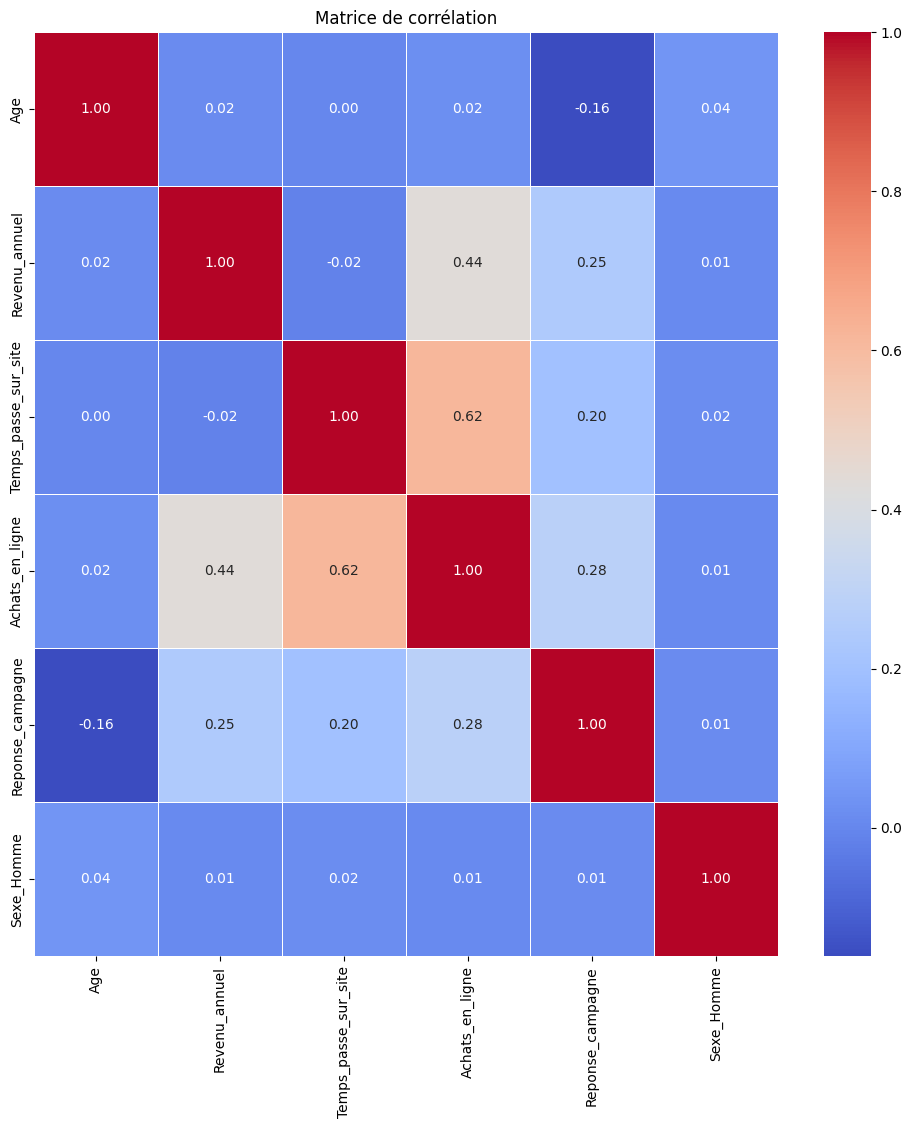

In [983]:
corr_matrix = response_encoded.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Matrice de corrélation")
plt.show()

Observations corrélation : 

Presque toutes les cases sont en bleu, ce qui nous montre ici une ABSENCE DE CORRELATION entre toutes les variables, aucune hétérogénéité (à part une corrélation un peu plus élevée de .62 entre le temps passé sur le site et les achats en ligne).

Ceci donne l'impression qu'aucune variable n'est discriminante dans notre jeu de données.

Les seuls éléments (corrélations) remarquables ici sont : le lien entre le temps passé sur le site et les achats en loigne (.62) et celui entre le revenu annuel et les achats en ligne (.44)

--> Ainsi, il y aurait donc un lien entre le temps passé sur le site et les achats, mais aussi (et logiquement) avec le revenu (qui impactera lui aussi l'achat)

--> Il y a une cause commune

--> Toujours pas d'information claire toutefois sur ce qui amènera les personnes à répondre à la campagne 

### Standardisation des données

In [984]:
# Séparation des variables (suivant votre exemple)
problem = response_df_clean.drop("Reponse_campagne", axis=1)
solution = response_df_clean["Reponse_campagne"]

In [985]:
# Encodage avec get_dummies
problem_encoded = pd.get_dummies(problem, columns=['Sexe'], drop_first=True)

# Standardisation
scaler_object = StandardScaler()
normalized_problem = scaler_object.fit_transform(problem_encoded)

# DataFrame standardisé
normalized_df = pd.DataFrame(normalized_problem, columns=problem_encoded.columns)

print("=== DONNÉES STANDARDISÉES ===")
print("Aperçu :")
print(normalized_df.head())

print(f"\nStatistiques descriptives :")
print(normalized_df.describe())

print(f"\n=== VÉRIFICATION DE LA STANDARDISATION ===")
print("Moyennes (doivent être ≈ 0) :")
print(normalized_df.mean().round(10))
print(f"\nÉcarts-types (doivent être ≈ 1) :")
print(normalized_df.std().round(10))

=== DONNÉES STANDARDISÉES ===
Aperçu :
        Age  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne  Sexe_Homme
0 -1.385373       1.969452             -1.383778         0.839109    1.028916
1 -0.330948       0.012363             -0.021211         0.219723   -0.971896
2 -0.752718       0.541118              1.175193         0.839109   -0.971896
3 -2.018028      -1.469794              1.745517         0.839109   -0.971896
4  1.039803      -0.849113             -0.144511        -1.638437    1.028916

Statistiques descriptives :
                Age  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne  \
count  2.351000e+03   2.351000e+03          2.351000e+03     2.351000e+03   
mean   9.860254e-17   3.173415e-17         -1.813380e-17     1.224032e-16   
std    1.000213e+00   1.000213e+00          1.000213e+00     1.000213e+00   
min   -2.228913e+00  -3.087505e+00         -3.347877e+00    -3.496597e+00   
25%   -7.527183e-01  -6.729081e-01         -6.721929e-01    -3.996638e-01   
50

## PCA

In [986]:
x_train, x_test, y_train, y_test = train_test_split(
    normalized_df, solution, random_state=42
)

In [987]:
feature_names = normalized_df.columns.tolist()
print("Features utilisées :", feature_names)

Features utilisées : ['Age', 'Revenu_annuel', 'Temps_passe_sur_site', 'Achats_en_ligne', 'Sexe_Homme']


#### Matrice des composantes (passage) : vue d'ensemble

In [988]:
# PCA avec résultats fixés
pca_object = PCA(random_state=42)
x_train_pca = pca_object.fit_transform(x_train)

matrice_passage = pd.DataFrame(
    pca_object.components_, 
    index=[f"PC_{i+1}" for i in range(pca_object.n_components_)],
    columns=problem_encoded.columns 
)

pd.DataFrame(matrice_passage)


,Age,Revenu_annuel,Temps_passe_sur_site,Achats_en_ligne,Sexe_Homme
PC_1,0.007247,0.379011,0.591596,0.710730,0.034280
PC_2,0.722216,-0.292330,0.172208,-0.023863,0.602264
PC_3,0.346565,0.775907,-0.515740,0.006743,0.108760
PC_4,-0.598530,0.099510,-0.086047,-0.013448,0.790110
PC_5,0.002416,-0.398698,-0.589039,0.702899,-0.000142


In [989]:
print(f"\n=== VARIANCE EXPLIQUÉE ===")

explained_variance = pca_object.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("explained_variance:", len(explained_variance))
print("cumulative_variance:", len(cumulative_variance))

print(f"\n=== VARIANCE EXPLIQUÉE par PC en % ===")

for i, variance in enumerate(explained_variance):
    print(f"PC_{i+1}: {variance:.1%}")


=== VARIANCE EXPLIQUÉE ===
explained_variance: 5
cumulative_variance: 5

=== VARIANCE EXPLIQUÉE par PC en % ===
PC_1: 35.7%
PC_2: 20.8%
PC_3: 19.8%
PC_4: 18.9%
PC_5: 4.7%


#### Graphique des variances expliquées (et cumulées) par composantes principales

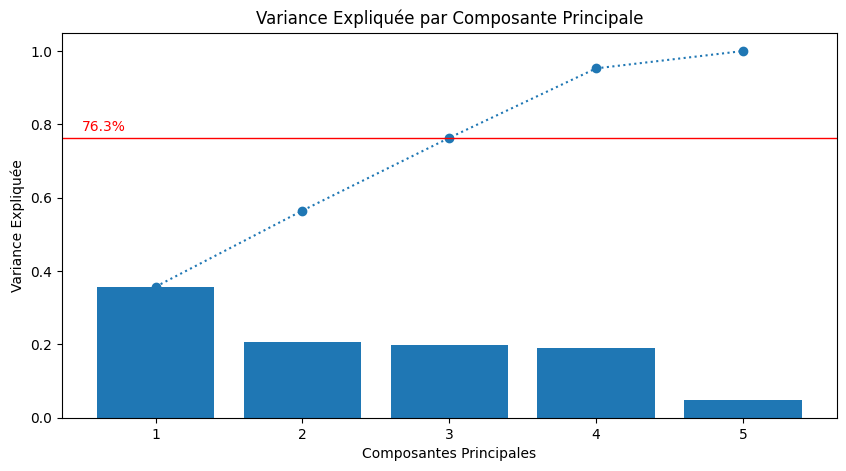

In [990]:
n = len(explained_variance)
plt.figure(figsize=(10, 5))
plt.xticks(ticks=range(1, n+1))
plt.bar(range(1, n+1), explained_variance)
plt.plot(range(1, n+1), cumulative_variance, "o:")

# Ligne rouge horizontale au niveau de la variance cumulée de PC_3
variance_cumul_pc3 = cumulative_variance[2]
plt.axhline(y=variance_cumul_pc3, color='red', linestyle='-', linewidth=1)

plt.text(0.5, variance_cumul_pc3 + 0.02, f'{variance_cumul_pc3:.1%}', 
         color='red')

plt.xlabel('Composantes Principales')
plt.ylabel('Variance Expliquée')
plt.title('Variance Expliquée par Composante Principale')

plt.show()

Nous observons que les trois premières composantes contiennent jusqu'à 76,3% des variances expliquées. Autrement dit, **76,3% de la variance de nos données peut être expliquée par nos trois premières composantes principales.**

### **Focus sur nos trois premières composantes principales, porteuses des informations principales**

#### Matrice de passage pour les trois composantes principales

In [991]:
matrice_passage_3pc = pd.DataFrame(
    pca_object.components_[:3],
    index=[f"PC_{i+1}" for i in range(3)],
    columns=problem_encoded.columns
)

pd.DataFrame(matrice_passage_3pc)

,Age,Revenu_annuel,Temps_passe_sur_site,Achats_en_ligne,Sexe_Homme
PC_1,0.007247,0.379011,0.591596,0.710730,0.034280
PC_2,0.722216,-0.292330,0.172208,-0.023863,0.602264
PC_3,0.346565,0.775907,-0.515740,0.006743,0.108760


#### Analyse : 

### *PC_1 (35,7%) : Axe de "L'Engagement Commercial (Achat, temps, revenu)"*

**Observation** : Les achats en lignent (.71) contribuent massivement à cette composante, suivis du temps passé sur le site (.60) et du revenu annuel (.38)

**Compréhension** : Il existerait une dimension d'activité e-commerce complètement indépendante de l'âge et du sexe

**Interprétation** : Mesure l'activité commerciale du client

**Les clients actifs (PC1_2levée)** = ceux qui achètent beaucoup + passent du temps sur le site + ont des revenus corrects

*Insight business : L'engagement commercial transcende les profils démographiques*

In [992]:
# Validation avec les extrêmes PC_1
print()
print("=== VALIDATION PC_1 : PROFILS EXTRÊMES ===")
pc1_high = x_train_pca[:, 0] > np.percentile(x_train_pca[:, 0], 80)
pc1_low = x_train_pca[:, 0] < np.percentile(x_train_pca[:, 0], 20)

x_train_df = pd.DataFrame(x_train, columns=problem_encoded.columns)

print("PC_1 ÉLEVÉ (Engagement commercial fort) :")
print(f"  Achats moyens: {x_train_df[pc1_high]['Achats_en_ligne'].mean():.2f}")
print(f"  Temps moyen: {x_train_df[pc1_high]['Temps_passe_sur_site'].mean():.2f}")
print(f"  Revenu moyen: {x_train_df[pc1_high]['Revenu_annuel'].mean():.2f}")
print(f"  Taux de réponse: {y_train[pc1_high].mean():.1%} ({pc1_high.sum()} clients)")

print("PC_1 FAIBLE (Engagement commercial faible) :")
print(f"  Achats moyens: {x_train_df[pc1_low]['Achats_en_ligne'].mean():.2f}")
print(f"  Temps moyen: {x_train_df[pc1_low]['Temps_passe_sur_site'].mean():.2f}")
print(f"  Revenu moyen: {x_train_df[pc1_low]['Revenu_annuel'].mean():.2f}")
print(f"  Taux de réponse: {y_train[pc1_low].mean():.1%} ({pc1_low.sum()} clients)")

print(f"\nTaux global: {y_train.mean():.1%}")


=== VALIDATION PC_1 : PROFILS EXTRÊMES ===
PC_1 ÉLEVÉ (Engagement commercial fort) :
  Achats moyens: 1.32
  Temps moyen: 1.15
  Revenu moyen: 0.69
  Taux de réponse: 74.5% (353 clients)
PC_1 FAIBLE (Engagement commercial faible) :
  Achats moyens: -1.33
  Temps moyen: -1.11
  Revenu moyen: -0.73
  Taux de réponse: 30.9% (353 clients)

Taux global: 52.2%


--> Nous observons 2 profils d'utilisateurs opposés ;

- Segment A : Clients Ultra-Engagés (achats fréquents, temps important sur le site, revenus confortables)
- Segment B : Clients Désengagés (achats rares, visites rapides, revenus modestes)

***QUESTION 1 : Y aurait-il un taux plus élevé de réponses pour ces profils repérés ?***

In [993]:
# ANALYSE COMPLÈTE PC_1 : ENGAGEMENT COMMERCIAL
train_indices = y_train.index
donnees_valides = problem_encoded.loc[train_indices]

# Définir les seuils pour PC_1 (Achats, Temps, Revenu)
achats_median = donnees_valides['Achats_en_ligne'].median()
temps_median = donnees_valides['Temps_passe_sur_site'].median() 
revenu_median = donnees_valides['Revenu_annuel'].median()

print("=== SEUILS PC_1 (ENGAGEMENT COMMERCIAL) ===")
print(f"Achats élevés: ≥ {achats_median:.1f}")
print(f"Plus de temps: > {temps_median:.1f}")
print(f"Revenus élevés: ≥ {revenu_median:.0f}")

print()

print("=== ANALYSE SIMPLE : VARIABLES PC_1 ===")
segments_pc1_simples = {
    'Achats Élevés': donnees_valides['Achats_en_ligne'] >= achats_median,
    'Achats Faibles': donnees_valides['Achats_en_ligne'] < achats_median,
    'Plus de Temps': donnees_valides['Temps_passe_sur_site'] > temps_median,
    'Moins de Temps': donnees_valides['Temps_passe_sur_site'] <= temps_median,
    'Revenus Élevés': donnees_valides['Revenu_annuel'] >= revenu_median,
    'Revenus Faibles': donnees_valides['Revenu_annuel'] < revenu_median
}

for nom, mask in segments_pc1_simples.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE : ACHATS × TEMPS (4 profils) ===")
segments_achats_temps = {
    'Achats Élevés + Plus Temps': (
        (donnees_valides['Achats_en_ligne'] >= achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'Achats Élevés + Moins Temps': (
        (donnees_valides['Achats_en_ligne'] >= achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'Achats Faibles + Plus Temps': (
        (donnees_valides['Achats_en_ligne'] < achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'Achats Faibles + Moins Temps': (
        (donnees_valides['Achats_en_ligne'] < achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    )
}

for nom, mask in segments_achats_temps.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE : ACHATS × REVENUS (4 profils) ===")
segments_achats_revenus = {
    'Achats Élevés + Revenus Élevés': (
        (donnees_valides['Achats_en_ligne'] >= achats_median) & 
        (donnees_valides['Revenu_annuel'] >= revenu_median)
    ),
    'Achats Élevés + Revenus Faibles': (
        (donnees_valides['Achats_en_ligne'] >= achats_median) & 
        (donnees_valides['Revenu_annuel'] < revenu_median)
    ),
    'Achats Faibles + Revenus Élevés': (
        (donnees_valides['Achats_en_ligne'] < achats_median) & 
        (donnees_valides['Revenu_annuel'] >= revenu_median)
    ),
    'Achats Faibles + Revenus Faibles': (
        (donnees_valides['Achats_en_ligne'] < achats_median) & 
        (donnees_valides['Revenu_annuel'] < revenu_median)
    )
}

for nom, mask in segments_achats_revenus.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE : TEMPS × REVENUS (4 profils) ===")
segments_temps_revenus = {
    'Plus Temps + Revenus Élevés': (
        (donnees_valides['Temps_passe_sur_site'] > temps_median) & 
        (donnees_valides['Revenu_annuel'] >= revenu_median)
    ),
    'Plus Temps + Revenus Faibles': (
        (donnees_valides['Temps_passe_sur_site'] > temps_median) & 
        (donnees_valides['Revenu_annuel'] < revenu_median)
    ),
    'Moins Temps + Revenus Élevés': (
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) & 
        (donnees_valides['Revenu_annuel'] >= revenu_median)
    ),
    'Moins Temps + Revenus Faibles': (
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) & 
        (donnees_valides['Revenu_annuel'] < revenu_median)
    )
}

for nom, mask in segments_temps_revenus.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE COMPLÈTE : 8 PROFILS PC_1 ===")
segments_pc1_complets = {
    'Achats Élevés + Plus Temps + Revenus Élevés': (
        (donnees_valides['Achats_en_ligne'] >= achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        (donnees_valides['Revenu_annuel'] >= revenu_median)
    ),
    'Achats Élevés + Plus Temps + Revenus Faibles': (
        (donnees_valides['Achats_en_ligne'] >= achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        (donnees_valides['Revenu_annuel'] < revenu_median)
    ),
    'Achats Élevés + Moins Temps + Revenus Élevés': (
        (donnees_valides['Achats_en_ligne'] >= achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        (donnees_valides['Revenu_annuel'] >= revenu_median)
    ),
    'Achats Élevés + Moins Temps + Revenus Faibles': (
        (donnees_valides['Achats_en_ligne'] >= achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        (donnees_valides['Revenu_annuel'] < revenu_median)
    ),
    'Achats Faibles + Plus Temps + Revenus Élevés': (
        (donnees_valides['Achats_en_ligne'] < achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        (donnees_valides['Revenu_annuel'] >= revenu_median)
    ),
    'Achats Faibles + Plus Temps + Revenus Faibles': (
        (donnees_valides['Achats_en_ligne'] < achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        (donnees_valides['Revenu_annuel'] < revenu_median)
    ),
    'Achats Faibles + Moins Temps + Revenus Élevés': (
        (donnees_valides['Achats_en_ligne'] < achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        (donnees_valides['Revenu_annuel'] >= revenu_median)
    ),
    'Achats Faibles + Moins Temps + Revenus Faibles': (
        (donnees_valides['Achats_en_ligne'] < achats_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        (donnees_valides['Revenu_annuel'] < revenu_median)
    )
}

for nom, mask in segments_pc1_complets.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")
    else:
        print(f"{nom}: 0 clients")



=== SEUILS PC_1 (ENGAGEMENT COMMERCIAL) ===
Achats élevés: ≥ 8.0
Plus de temps: > 22.0
Revenus élevés: ≥ 26125

=== ANALYSE SIMPLE : VARIABLES PC_1 ===
Achats Élevés: 61.4% (939 clients)
Achats Faibles: 41.6% (824 clients)
Plus de Temps: 60.4% (881 clients)
Moins de Temps: 44.0% (882 clients)
Revenus Élevés: 62.6% (882 clients)
Revenus Faibles: 41.8% (881 clients)

=== ANALYSE CROISÉE : ACHATS × TEMPS (4 profils) ===
Achats Élevés + Plus Temps: 64.5% (667 clients)
Achats Élevés + Moins Temps: 54.0% (272 clients)
Achats Faibles + Plus Temps: 47.7% (214 clients)
Achats Faibles + Moins Temps: 39.5% (610 clients)

=== ANALYSE CROISÉE : ACHATS × REVENUS (4 profils) ===
Achats Élevés + Revenus Élevés: 67.1% (596 clients)
Achats Élevés + Revenus Faibles: 51.6% (343 clients)
Achats Faibles + Revenus Élevés: 53.1% (286 clients)
Achats Faibles + Revenus Faibles: 35.5% (538 clients)

=== ANALYSE CROISÉE : TEMPS × REVENUS (4 profils) ===
Plus Temps + Revenus Élevés: 67.6% (442 clients)
Plus Temps 

***RÉPONSE 1 : OUI***

--> Corrélation légère d'ores et déjà visible dans la matrice de corélation entre temps et achats (.6), plus légèrement entre revenus et achats (.4)

--> Les clients présentant un **engagement commercial complet (achats élevés + temps important + revenus élevés)** atteignent un taux de réponse exceptionnel de 70,2%

--> paradoxe intéressant : même avec des achats élevés, l'absence des autres facteurs d'engagement peut conduire à des performances décevantes, soulignant que PC_1 capture véritablement un engagement global plutôt qu'une simple activité d'achat.


### *PC_2 (20,8%) : Axe de "Profil Démographique - âge et sexe (+revenu/temps)"*

**Observation** : L'âge (.71) et le sexe masculin (.69) contribuent massivement à cette composante - suivi d'une contribution plus faible du temps passé sur le site (.17) et une variance inverse avec le revenu annuel (-.29)

**Compréhension** : Il existe une dimension démographique qui combine âge et genre masculin, complètement indépendante de l'activité commerciale

**Interprétation** : Les profils démographiques forment des groupes distincts

**Le profil client (PC_2 élevée)** = hommes plutôt âgés (avec potentiellement moins de revenus et plus de temps sur le site)

*Insight business : Les caractéristiques démographiques forment une dimension à part, suggérant des segments de clientèle distincts selon l'âge et le genre, ainsi que le revenu et le temps passé sur le site*

(Mais attention, ce profil n'est pas lié à l'engagement commercial 

Il ne signifie en rien qu'être un homme âgé amène à plus d'achats 
--> Sinon, cette dimension serait intervenue dans le PC1)


In [994]:
# Validation avec les extrêmes PC_2 (Age + Sexe + Revenu)
print()
print("=== VALIDATION PC_2 : PROFILS EXTRÊMES ===")
pc2_high = x_train_pca[:, 1] > np.percentile(x_train_pca[:, 1], 80)
pc2_low = x_train_pca[:, 1] < np.percentile(x_train_pca[:, 1], 20)

x_train_df = pd.DataFrame(x_train, columns=problem_encoded.columns)

print("PC_2 ÉLEVÉ (Hommes âgés, revenus modestes) :")
print(f"  Age moyen: {x_train_df[pc2_high]['Age'].mean():.2f}")
print(f"  % Hommes: {x_train_df[pc2_high]['Sexe_Homme'].mean():.1%}")
print(f"  Revenu moyen: {x_train_df[pc2_high]['Revenu_annuel'].mean():.2f}")
print(f"  Taux de réponse: {y_train[pc2_high].mean():.1%} ({pc2_high.sum()} clients)")

print("PC_2 FAIBLE (Femmes jeunes, revenus élevés) :")
print(f"  Age moyen: {x_train_df[pc2_low]['Age'].mean():.2f}")
print(f"  % Hommes: {x_train_df[pc2_low]['Sexe_Homme'].mean():.1%}")
print(f"  Revenu moyen: {x_train_df[pc2_low]['Revenu_annuel'].mean():.2f}")
print(f"  Taux de réponse: {y_train[pc2_low].mean():.1%} ({pc2_low.sum()} clients)")

print()


=== VALIDATION PC_2 : PROFILS EXTRÊMES ===
PC_2 ÉLEVÉ (Hommes âgés, revenus modestes) :
  Age moyen: 1.12
  % Hommes: 83.1%
  Revenu moyen: -0.38
  Taux de réponse: 44.8% (353 clients)
PC_2 FAIBLE (Femmes jeunes, revenus élevés) :
  Age moyen: -1.03
  % Hommes: -87.6%
  Revenu moyen: 0.38
  Taux de réponse: 67.7% (353 clients)




--> Nous observons 2 profils d'utilisateurs opposés ; 

- *Segment A : Hommes âgés (revenus plus modestes, très actifs sur le site)
- *Segment B : Femmes jeunes (plus aisées financièrement, moins actives sur le site)

--> Cependant, s'il y avait seulement des femmes jeunes sur le site e-commerce et des hommes âgés, nous aurions obtenus une corrélation entre l'âge et le sexe dans la matrice de corrélation, ou encore des proportions inégalitaires en terme d'hommes/femmes/jeunes/vieux, CE QUI N'EST PAS LE CAS

--> DONC, ces tendances pourrait s'observer selon une AUTRE VARIABLE --> Cause commune

**--> Se pourrait-il que ce soit notre target ?**

***QUESTION 2 : Y aurait-il un taux plus élevé de réponses pour ces profils repérés ?***

In [1015]:
# 1. ANALYSE SIMPLE AVEC 3 CATÉGORIES D'ÂGE
train_indices = y_train.index
donnees_valides = problem_encoded.loc[train_indices]

# Créer 3 catégories d'âge
age_33_percentile = donnees_valides['Age'].quantile(0.33)
age_67_percentile = donnees_valides['Age'].quantile(0.67)
revenu_median = donnees_valides['Revenu_annuel'].median()
temps_median = donnees_valides['Temps_passe_sur_site'].median()

# Compter les effectifs par tranche d'âge
tres_jeunes = donnees_valides['Age'] < age_33_percentile
jeunes = (donnees_valides['Age'] >= age_33_percentile) & (donnees_valides['Age'] < age_67_percentile)
ages = donnees_valides['Age'] >= age_67_percentile

print("=== SEUILS UTILISÉS (3 CATÉGORIES) ===")
print(f"Très jeunes: < {age_33_percentile:.1f} ans ({tres_jeunes.sum()} clients)")
print(f"Jeunes: {age_33_percentile:.1f} - {age_67_percentile:.1f} ans ({jeunes.sum()} clients)")
print(f"Âgés: ≥ {age_67_percentile:.1f} ans ({ages.sum()} clients)")

print()

print("=== 1. ANALYSE SIMPLE AGE/SEXE (3 catégories) ===")
segments_simples_3age = {
    'Hommes Très Jeunes': tres_jeunes & (donnees_valides['Sexe_Homme'] == 1),
    'Hommes Jeunes': jeunes & (donnees_valides['Sexe_Homme'] == 1),
    'Hommes Âgés': ages & (donnees_valides['Sexe_Homme'] == 1),
    'Femmes Très Jeunes': tres_jeunes & (donnees_valides['Sexe_Homme'] == 0),
    'Femmes Jeunes': jeunes & (donnees_valides['Sexe_Homme'] == 0),
    'Femmes Âgées': ages & (donnees_valides['Sexe_Homme'] == 0)
}

for nom, mask in segments_simples_3age.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE COMPLÈTE (18 segments) ===")
segments_complets_18 = {
    # Hommes Très Jeunes - 3 segments
    'H.Très Jeunes + Peu Rev + Plus Temps': (
        tres_jeunes & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'H.Très Jeunes + Peu Rev + Moins Temps': (
        tres_jeunes & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'H.Très Jeunes + Bcp Rev + Moins Temps': (
        tres_jeunes & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'H.Très Jeunes + Bcp Rev + Plus Temps': (
        tres_jeunes & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    
    # Hommes Jeunes - 3 segments
    'H.Jeunes + Peu Rev + Plus Temps': (
        jeunes & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'H.Jeunes + Peu Rev + Moins Temps': (
        jeunes & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'H.Jeunes + Bcp Rev + Moins Temps': (
        jeunes & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'H.Jeunes + Bcp Rev + Plus Temps': (
        jeunes & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    
    # Hommes Âgés - 3 segments
    'H.Âgés + Peu Rev + Plus Temps': (
        ages & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'H.Âgés + Peu Rev + Moins Temps': (
        ages & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'H.Âgés + Bcp Rev + Moins Temps': (
        ages & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'H.Âgés + Bcp Rev + Plus Temps': (
        ages & (donnees_valides['Sexe_Homme'] == 1) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    
    # Femmes Très Jeunes - 3 segments
    'F.Très Jeunes + Peu Rev + Plus Temps': (
        tres_jeunes & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'F.Très Jeunes + Peu Rev + Moins Temps': (
        tres_jeunes & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'F.Très Jeunes + Bcp Rev + Moins Temps': (
        tres_jeunes & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'F.Très Jeunes + Bcp Rev + Plus Temps': (
        tres_jeunes & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    
    # Femmes Jeunes - 3 segments
    'F.Jeunes + Peu Rev + Plus Temps': (
        jeunes & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'F.Jeunes + Peu Rev + Moins Temps': (
        jeunes & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'F.Jeunes + Bcp Rev + Moins Temps': (
        jeunes & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'F.Jeunes + Bcp Rev + Plus Temps': (
        jeunes & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    
    # Femmes Âgées - 3 segments
    'F.Âgées + Peu Rev + Plus Temps': (
        ages & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'F.Âgées + Peu Rev + Moins Temps': (
        ages & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] < revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'F.Âgées + Bcp Rev + Moins Temps': (
        ages & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'F.Âgées + Bcp Rev + Plus Temps': (
        ages & (donnees_valides['Sexe_Homme'] == 0) &
        (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median)
    )
}

# Affichage des résultats
for nom, mask in segments_complets_18.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")
    else:
        print(f"{nom}: 0 clients")

# Vérification du total
total_segments = sum(mask.sum() for mask in segments_complets_18.values())
print(f"\nTotal segments: {total_segments}/{len(donnees_valides)} clients")

# Vérification que tous les clients sont comptés
if total_segments == len(donnees_valides):
    print("✅ Tous les clients sont bien répartis dans les 18 segments")
else:
    print(f"⚠️ Il manque {len(donnees_valides) - total_segments} clients")

=== SEUILS UTILISÉS (3 CATÉGORIES) ===
Très jeunes: < 31.0 ans (581 clients)
Jeunes: 31.0 - 40.0 ans (593 clients)
Âgés: ≥ 40.0 ans (589 clients)

=== 1. ANALYSE SIMPLE AGE/SEXE (3 catégories) ===
Hommes Très Jeunes: 64.3% (252 clients)
Hommes Jeunes: 49.1% (277 clients)
Hommes Âgés: 46.6% (298 clients)
Femmes Très Jeunes: 66.9% (329 clients)
Femmes Jeunes: 46.2% (316 clients)
Femmes Âgées: 40.2% (291 clients)

=== ANALYSE CROISÉE COMPLÈTE (18 segments) ===
H.Très Jeunes + Peu Rev + Plus Temps: 65.7% (67 clients)
H.Très Jeunes + Peu Rev + Moins Temps: 40.4% (57 clients)
H.Très Jeunes + Bcp Rev + Moins Temps: 69.5% (59 clients)
H.Très Jeunes + Bcp Rev + Plus Temps: 78.3% (69 clients)
H.Jeunes + Peu Rev + Plus Temps: 53.1% (64 clients)
H.Jeunes + Peu Rev + Moins Temps: 30.1% (73 clients)
H.Jeunes + Bcp Rev + Moins Temps: 45.9% (61 clients)
H.Jeunes + Bcp Rev + Plus Temps: 65.8% (79 clients)
H.Âgés + Peu Rev + Plus Temps: 49.4% (79 clients)
H.Âgés + Peu Rev + Moins Temps: 19.1% (68 client

***RÉPONSE 2 : OUI ET NON***

#### Observation principale : 

--> L'écart le plus marquant s'observe chez les **femmes très jeunes**, surtout celles avec **beaucoup de revenus et moins de temps passé sur le site** (*en partie en lien avec le profil repéré précédemment, mais l'inverse, donc les hommes plus âgés avec peu de revenus et plus de temps, ne s'applique pas*)

--> à l'inverse, les personnes **âgées (H/F) avec peu de revenus et moins de temps** vont beaucoup moins répondre à la campagne

--> On pourrait mettre en avant le fait que **les personnes plus jeunes**, de façon générale, ont un taux de réponse légèrement plus élevé en général. L'écart se creuse encore plus chez les femmes. 

### *PC_3 (19,8%) : Axe de "Richesse - revenus et temps (+âge)"*

**Observation** : Le revenu annuel (.78) contribue massivement à cette composante, suivi de l'âge (.35), avec une contribution inverse importante du temps passé sur le site (-.52).

**Compréhension** : Il existe une dimension qui oppose le statut socio-économique au comportement de navigation, complètement déconnectée de l'activité commerciale (achats).

**Interprétation** : Mesure l'opposition entre pouvoir d'achat et temps de navigation

**Le profil client (PC_3 élevée)** = clients aisés (et plus mûrs) qui naviguent peu sur le site (comportement "efficace")

*Insight business : PC_3 révèle que richesse ≠ engagement digital. Les clients fortunés optimisent leur temps de navigation.*

In [996]:
# Validation avec les extrêmes PC_3 (Revenu + Temps + Age)
print("=== VALIDATION PC_3 : PROFILS EXTRÊMES ===")
pc3_high = x_train_pca[:, 2] > np.percentile(x_train_pca[:, 2], 80)
pc3_low = x_train_pca[:, 2] < np.percentile(x_train_pca[:, 2], 20)

print("PC_3 ÉLEVÉ (Revenus élevés, âgés, moins de temps) :")
print(f"  Revenu moyen: {x_train_df[pc3_high]['Revenu_annuel'].mean():.2f}")
print(f"  Age moyen: {x_train_df[pc3_high]['Age'].mean():.2f}")
print(f"  Temps moyen: {x_train_df[pc3_high]['Temps_passe_sur_site'].mean():.2f}")
print(f"  Taux de réponse: {y_train[pc3_high].mean():.1%} ({pc3_high.sum()} clients)")

print("PC_3 FAIBLE (Revenus faibles, jeunes, plus de temps) :")
print(f"  Revenu moyen: {x_train_df[pc3_low]['Revenu_annuel'].mean():.2f}")
print(f"  Age moyen: {x_train_df[pc3_low]['Age'].mean():.2f}")
print(f"  Temps moyen: {x_train_df[pc3_low]['Temps_passe_sur_site'].mean():.2f}")
print(f"  Taux de réponse: {y_train[pc3_low].mean():.1%} ({pc3_low.sum()} clients)")

print(f"\nTaux global: {y_train.mean():.1%}")

=== VALIDATION PC_3 : PROFILS EXTRÊMES ===
PC_3 ÉLEVÉ (Revenus élevés, âgés, moins de temps) :
  Revenu moyen: 1.05
  Age moyen: 0.55
  Temps moyen: -0.74
  Taux de réponse: 59.2% (353 clients)
PC_3 FAIBLE (Revenus faibles, jeunes, plus de temps) :
  Revenu moyen: -1.12
  Age moyen: -0.47
  Temps moyen: 0.70
  Taux de réponse: 56.1% (353 clients)

Taux global: 52.2%


--> Nous observons 2 profils d'utilisateurs opposés ; 

- *Segment A : Les clients aisés et plus âgés qui naviguent peu sur le site
- *Segment B : Les clients pauvres et plus jeunes navigant davantage

***QUESTION 3 : Pourrai-il y avoir un lien entre ce profil et la target ?***

In [997]:
# ANALYSE PC_3 AVEC 3 CATÉGORIES D'ÂGE
train_indices = y_train.index
donnees_valides = problem_encoded.loc[train_indices]

revenu_median = donnees_valides['Revenu_annuel'].median()
temps_median = donnees_valides['Temps_passe_sur_site'].median()

# Créer 3 catégories d'âge
age_33_percentile = donnees_valides['Age'].quantile(0.33)
age_67_percentile = donnees_valides['Age'].quantile(0.67)

# Compter les effectifs par tranche
tres_jeunes = donnees_valides['Age'] < age_33_percentile
jeunes = (donnees_valides['Age'] >= age_33_percentile) & (donnees_valides['Age'] < age_67_percentile)
ages = donnees_valides['Age'] >= age_67_percentile

print("=== SEUILS D'ÂGE (3 CATÉGORIES) ===")
print(f"Très jeunes: < {age_33_percentile:.1f} ans ({tres_jeunes.sum()} clients)")
print(f"Jeunes: {age_33_percentile:.1f} - {age_67_percentile:.1f} ans ({jeunes.sum()} clients)")
print(f"Âgés: ≥ {age_67_percentile:.1f} ans ({ages.sum()} clients)")

print()

print("=== ANALYSE SIMPLE : REVENU/TEMPS/ÂGE (3 catégories) ===")
segments_age_3 = {
    'Revenus Élevés': donnees_valides['Revenu_annuel'] >= revenu_median,
    'Revenus Faibles': donnees_valides['Revenu_annuel'] < revenu_median,
    'Plus de Temps': donnees_valides['Temps_passe_sur_site'] > temps_median,
    'Moins de Temps': donnees_valides['Temps_passe_sur_site'] <= temps_median,
    'Très Jeunes': tres_jeunes,
    'Jeunes': jeunes,
    'Âgés': ages
}

for nom, mask in segments_age_3.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE : REVENU × TEMPS (4 profils) ===")
segments_revenu_temps = {
    'Revenus Élevés + Plus de Temps': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'Revenus Élevés + Moins de Temps': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    ),
    'Revenus Faibles + Plus de Temps': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median)
    ),
    'Revenus Faibles + Moins de Temps': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median)
    )
}

for nom, mask in segments_revenu_temps.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE : REVENU × ÂGE (6 profils) ===")
segments_revenu_age = {
    'Revenus Élevés + Très Jeunes': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & tres_jeunes
    ),
    'Revenus Élevés + Jeunes': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & jeunes
    ),
    'Revenus Élevés + Âgés': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & ages
    ),
    'Revenus Faibles + Très Jeunes': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & tres_jeunes
    ),
    'Revenus Faibles + Jeunes': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & jeunes
    ),
    'Revenus Faibles + Âgés': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & ages
    )
}

for nom, mask in segments_revenu_age.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE : TEMPS × ÂGE (6 profils) ===")
segments_temps_age = {
    'Plus de Temps + Très Jeunes': (
        (donnees_valides['Temps_passe_sur_site'] > temps_median) & tres_jeunes
    ),
    'Plus de Temps + Jeunes': (
        (donnees_valides['Temps_passe_sur_site'] > temps_median) & jeunes
    ),
    'Plus de Temps + Âgés': (
        (donnees_valides['Temps_passe_sur_site'] > temps_median) & ages
    ),
    'Moins de Temps + Très Jeunes': (
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) & tres_jeunes
    ),
    'Moins de Temps + Jeunes': (
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) & jeunes
    ),
    'Moins de Temps + Âgés': (
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) & ages
    )
}

for nom, mask in segments_temps_age.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")

print()

print("=== ANALYSE CROISÉE : 12 PROFILS REVENU/TEMPS/ÂGE ===")
segments_complets_3age = {
    'Rev Élevés + Moins Temps + Très Jeunes': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        tres_jeunes
    ),
    'Rev Élevés + Moins Temps + Jeunes': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        jeunes
    ),
    'Rev Élevés + Moins Temps + Âgés': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        ages
    ),
    'Rev Élevés + Plus Temps + Très Jeunes': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        tres_jeunes
    ),
    'Rev Élevés + Plus Temps + Jeunes': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        jeunes
    ),
    'Rev Élevés + Plus Temps + Âgés': (
        (donnees_valides['Revenu_annuel'] >= revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        ages
    ),
    'Rev Faibles + Moins Temps + Très Jeunes': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        tres_jeunes
    ),
    'Rev Faibles + Moins Temps + Jeunes': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        jeunes
    ),
    'Rev Faibles + Moins Temps + Âgés': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] <= temps_median) &
        ages
    ),
    'Rev Faibles + Plus Temps + Très Jeunes': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        tres_jeunes
    ),
    'Rev Faibles + Plus Temps + Jeunes': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        jeunes
    ),
    'Rev Faibles + Plus Temps + Âgés': (
        (donnees_valides['Revenu_annuel'] < revenu_median) & 
        (donnees_valides['Temps_passe_sur_site'] > temps_median) &
        ages
    )
}

for nom, mask in segments_complets_3age.items():
    if mask.sum() > 0:
        taux_reponse = y_train[mask].mean()
        effectif = mask.sum()
        print(f"{nom}: {taux_reponse:.1%} ({effectif} clients)")
    else:
        print(f"{nom}: 0 clients")

print(f"\nTaux global: {y_train.mean():.1%}")

=== SEUILS D'ÂGE (3 CATÉGORIES) ===
Très jeunes: < 31.0 ans (581 clients)
Jeunes: 31.0 - 40.0 ans (593 clients)
Âgés: ≥ 40.0 ans (589 clients)

=== ANALYSE SIMPLE : REVENU/TEMPS/ÂGE (3 catégories) ===
Revenus Élevés: 62.6% (882 clients)
Revenus Faibles: 41.8% (881 clients)
Plus de Temps: 60.4% (881 clients)
Moins de Temps: 44.0% (882 clients)
Très Jeunes: 65.7% (581 clients)
Jeunes: 47.6% (593 clients)
Âgés: 43.5% (589 clients)

=== ANALYSE CROISÉE : REVENU × TEMPS (4 profils) ===
Revenus Élevés + Plus de Temps: 67.6% (442 clients)
Revenus Élevés + Moins de Temps: 57.5% (440 clients)
Revenus Faibles + Plus de Temps: 53.1% (439 clients)
Revenus Faibles + Moins de Temps: 30.5% (442 clients)

=== ANALYSE CROISÉE : REVENU × ÂGE (6 profils) ===
Revenus Élevés + Très Jeunes: 76.7% (287 clients)
Revenus Élevés + Jeunes: 56.5% (299 clients)
Revenus Élevés + Âgés: 55.1% (296 clients)
Revenus Faibles + Très Jeunes: 55.1% (294 clients)
Revenus Faibles + Jeunes: 38.4% (294 clients)
Revenus Faibles

***RÉPONSE 3 : NON***

#### Observation principale : 

--> Le profil le plus marqué (avec le plus grand taux de réponse) sont les **personnes très jeunes (< 31 ans) aux revenus élevés (indépendemment du temps passé sur le site**), or, la PCA met en avant un pofil type clients aisés (et plus mûrs) qui naviguent peu sur le site (comportement "efficace") ou à l'inverse, des clients pauvres (et jeunes) naviguant plus régulièrement.

--> Là aussi, ce sont les profils **"très jeunes"** qui ressortent davantage, associés à **plus d'argent**, idéalement avec du temps sur site (77.9%) mais pas nécessairement (75.4)

--> Les personnes à éviter à tout prix pour la campagne seraient les **personnes âgées, avec très peu de temps passé sur le site, et aux faibles revenus**.

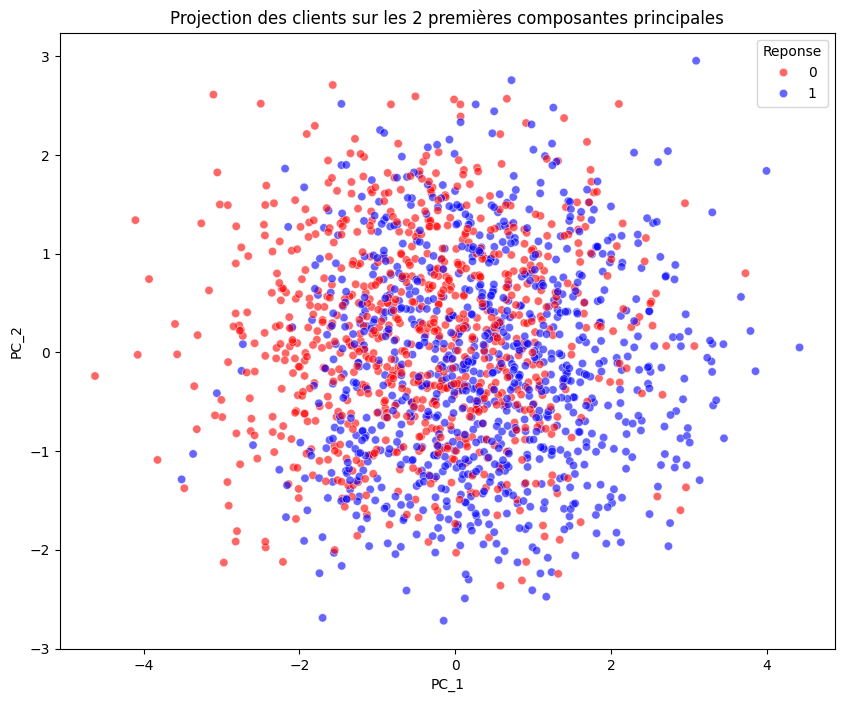

In [998]:
df_plot = pd.DataFrame({
    'PC_1': x_train_pca[:, 0],
    'PC_2': x_train_pca[:, 1], 
    'Reponse': y_train
})

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_plot, x='PC_1', y='PC_2', hue='Reponse', 
                palette=['red', 'blue'], alpha=0.6)
plt.title('Projection des clients sur les 2 premières composantes principales')
plt.show()

Le schéma en 2D de PC1 et PC2 ne nous donne pas beaucoup d'information au niveau visuel.

### Croisement des observations pour la PCA et le taux de réponse en fonction des variables croisées : 

In [999]:
# TOP 5 - TAUX DE RÉPONSE + EFFECTIFS
train_indices = y_train.index
donnees_valides = problem_encoded.loc[train_indices]

age_33_percentile = donnees_valides['Age'].quantile(0.33)
revenu_median = donnees_valides['Revenu_annuel'].median()
temps_median = donnees_valides['Temps_passe_sur_site'].median()
achats_median = donnees_valides['Achats_en_ligne'].median()

# Les 5 profils
profils = [
    # 1. F.Très Jeunes + Riches + Moins Temps + Bcp Achats
    (donnees_valides['Age'] < age_33_percentile) & (donnees_valides['Sexe_Homme'] == 0) & 
    (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median) & 
    (donnees_valides['Achats_en_ligne'] >= achats_median),
    
    # 2. F.Très Jeunes + Riches + Bcp Achats (général)
    (donnees_valides['Age'] < age_33_percentile) & (donnees_valides['Sexe_Homme'] == 0) & 
    (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Achats_en_ligne'] >= achats_median),
    
    # 3. F.Très Jeunes + Riches + Plus Temps + Bcp Achats
    (donnees_valides['Age'] < age_33_percentile) & (donnees_valides['Sexe_Homme'] == 0) & 
    (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] > temps_median) & 
    (donnees_valides['Achats_en_ligne'] >= achats_median),
    
    # 4. H.Très Jeunes + Riches + Bcp Achats
    (donnees_valides['Age'] < age_33_percentile) & (donnees_valides['Sexe_Homme'] == 1) & 
    (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Achats_en_ligne'] >= achats_median),
    
    # 5. F.Très Jeunes + Riches + Moins Temps
    (donnees_valides['Age'] < age_33_percentile) & (donnees_valides['Sexe_Homme'] == 0) & 
    (donnees_valides['Revenu_annuel'] >= revenu_median) & (donnees_valides['Temps_passe_sur_site'] <= temps_median)
]

noms = [
    "1. F.Très Jeunes + Riches + Moins Temps + Bcp Achats",
    "2. F.Très Jeunes + Riches + Bcp Achats (général)", 
    "3. F.Très Jeunes + Riches + Plus Temps + Bcp Achats",
    "4. H.Très Jeunes + Riches + Bcp Achats",
    "5. F.Très Jeunes + Riches + Moins Temps"
]

for i, (nom, mask) in enumerate(zip(noms, profils)):
    taux = y_train[mask].mean()
    effectif = mask.sum()
    print(f"{nom}: {taux:.1%} de réponses ({effectif} clients)")

1. F.Très Jeunes + Riches + Moins Temps + Bcp Achats: 83.3% de réponses (42 clients)
2. F.Très Jeunes + Riches + Bcp Achats (général): 81.8% de réponses (110 clients)
3. F.Très Jeunes + Riches + Plus Temps + Bcp Achats: 80.9% de réponses (68 clients)
4. H.Très Jeunes + Riches + Bcp Achats: 79.8% de réponses (89 clients)
5. F.Très Jeunes + Riches + Moins Temps: 79.5% de réponses (83 clients)


#### Le facteur le plus déterminant est l'ÂGE (les très jeunes, < 31 ans) et le SEXE (femmes), le REVENU ÉLEVÉ (≥ 26,125€), tout cela associé à un GRAND TAUX D'ACHATS (≥ 8 achats/semestre) pour la réponse à la campagne

### Le profil le plus efficace serait une TRÈS JEUNE Femme (< 31 ans) avec de hauts revenus (≥ 26,125€) ayant effectué un grand nombre d'achats (≥ 8 achats/semestre)

#### ***Portrait de la Cliente Idéale***

Marie, 25 ans, représente le profil client parfait. Jeune active en début de carrière, elle dispose d'un revenu annuel de 32,640€ qui lui permet un mode de vie confortable. Née avec le digital, elle navigue naturellement sur les sites e-commerce, y consacrant en moyenne 23 minutes par visite - un temps qui témoigne de son engagement et de sa confiance envers les marques qu'elle fréquente.

Son comportement d'achat révèle une consommatrice avertie et fidèle. Avec 9 commandes par semestre, elle dépasse largement la moyenne. Elle sait ce qu'elle veut, compare efficacement et n'hésite pas à acheter lorsqu'un produit correspond à ses attentes. Son pouvoir d'achat lui permet d'être réceptive aux nouveautés et aux gammes premium.

Marie incarne la génération des digital natives urbaines aisées qui ont fait du e-commerce leur mode d'achat privilégié. Connectée et influente sur les réseaux sociaux, elle représente non seulement une cliente à forte valeur ajoutée - avec un taux de réponse exceptionnel de 81,8% aux campagnes marketing - mais aussi une prescriptrice potentielle auprès de son entourage.

Ce segment de 110 clientes constitue véritablement une mine d'or commerciale, justifiant des stratégies marketing dédiées et personnalisées pour cette cible ultra-performante.


### Les profils les moins récéptifs à la campagne sont les clients "âgés" (≥40 ans)  avec peu d'engagement (revenus faibles (<26,125€) + peu de temps sur le site (≤22 min sur site), peu d'achats (< 8))

#### ***Portrait de la Cliente à Éviter***

Martine, 48 ans, représente le profil client le moins rentable. Avec des revenus modestes de 22,000€ et un comportement d'achat limité (moins de 8 commandes par semestre), elle navigue rapidement sur les sites e-commerce sans s'engager véritablement.

Son taux de réponse de seulement 15.2% aux campagnes marketing en fait le segment le moins réactif de la clientèle. Contrainte par son budget, elle privilégie systématiquement les achats essentiels et résiste naturellement aux sollicitations commerciales.

Ce segment de 66 clientes génère un retour sur investissement marketing particulièrement faible et nécessite une approche commerciale différenciée.

## **3. Modélisation (modèles & métriques)**

### Choix et justification des modèles de classification : 

*Dans le cadre de cette étude prédictive, nous avons sélectionné quatre modèles de classification complémentaires pour optimiser performance et interprétabilité.*

1. **La régression logistique constituerait notre modèle de référence** car elle est parfaitement adaptée à notre problématique binaire (réponse/non-réponse) et permet une interprétation directe des coefficients. Sa robustesse avec les données standardisées issues de notre PCA en fait un choix méthodologiquement cohérent pour quantifier l'impact de chaque variable sur la probabilité de réponse.

2. **Le Random Forest représenterait notre modèle de performance intermédiaire** grâce à sa capacité à capturer les interactions complexes entre variables, particulièrement pertinentes au regard de nos découvertes sur les synergies âge-revenus-comportement d'achat. Son score d'importance des variables validera empiriquement la hiérarchie révélée par notre analyse exploratoire.

3. **XGBoost représenterait notre modèle de performance maximale** en optimisant le gradient boosting pour exploiter pleinement les patterns complexes identifiés dans nos segments clients. Particulièrement efficace sur les données tabulaires comme les nôtres, il permettra d'atteindre la meilleure accuracy possible tout en gérant naturellement les déséquilibres entre segments.

4. **L'arbre de décision complèterait cette approche** en traduisant nos insights en règles métier directement exploitables, facilitant la création de segments opérationnels et la mise en œuvre des stratégies de ciblage identifiées.
Cette stratégie multi-modèles garantit une approche scientifique rigoureuse tout en préservant l'applicabilité opérationnelle des résultats.

**Les autres approches ont été écartées pour des raisons méthodologiques précises** : SVM et KNN manquent d'interprétabilité business essentielle pour traduire les résultats en recommandations marketing actionnables, et KNN souffre additionnellement du déséquilibre marqué de nos segments (110 femmes très jeunes riches vs 66 femmes âgées pauvres) qui fausserait les calculs de proximité (sauf si augmentation des données). K-means relève du clustering non-supervisé inadapté à notre objectif prédictif, d'autant plus que notre analyse PCA a déjà révélé que *les structures naturelles de variance des données (PC_2 et PC_3) ne correspondent que partiellement aux patterns prédictifs de la target* - seule PC_1 montrant une forte corrélation avec la réponse aux campagnes. Les tests statistiques (t-test, ANOVA) constituent des outils descriptifs complémentaires mais non prédictifs, plus appropriés pour valider a posteriori les différences entre segments qu'à l'élaboration de modèles de classification opérationnels.

## 1. Régression logistique

In [1000]:
log_model = LogisticRegression(random_state=42)
log_model.fit(x_train, y_train)
log_pred = log_model.predict(x_test)

print("Régression Logistique")
print("F1-score :", f1_score(y_test, log_pred))
print("Classification Report :\n", classification_report(y_test, log_pred))

Régression Logistique
F1-score : 0.6870229007633588
Classification Report :
               precision    recall  f1-score   support

           0       0.65      0.57      0.61       278
           1       0.65      0.73      0.69       310

    accuracy                           0.65       588
   macro avg       0.65      0.65      0.65       588
weighted avg       0.65      0.65      0.65       588



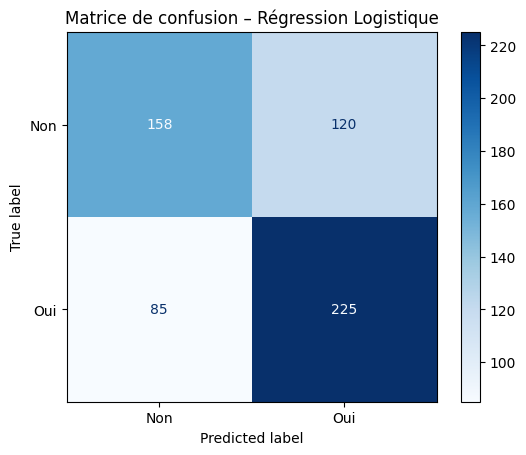

In [1001]:
cm_log = confusion_matrix(y_test, log_pred)
disp_log = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=["Non", "Oui"])
disp_log.plot(cmap="Blues")
plt.title("Matrice de confusion – Régression Logistique")
plt.show()

In [1002]:
# Optimisation du modèle avec le gridsearch
log_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear'],
}

log_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    log_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

log_grid.fit(x_train, y_train)
best_log_model = log_grid.best_estimator_
log_pred = best_log_model.predict(x_test)

print("Régression Logistique avec GridSearch et paramètres optimisés")
print("Meilleurs paramètres :", log_grid.best_params_)
print("F1-score (validation croisée) :", log_grid.best_score_)
print("F1-score (test set) :", f1_score(y_test, log_pred))
print("\nClassification report :\n", classification_report(y_test, log_pred))


Régression Logistique avec GridSearch et paramètres optimisés
Meilleurs paramètres : {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
F1-score (validation croisée) : 0.6713872043190333
F1-score (test set) : 0.6930091185410334

Classification report :
               precision    recall  f1-score   support

           0       0.66      0.57      0.61       278
           1       0.66      0.74      0.69       310

    accuracy                           0.66       588
   macro avg       0.66      0.65      0.65       588
weighted avg       0.66      0.66      0.65       588



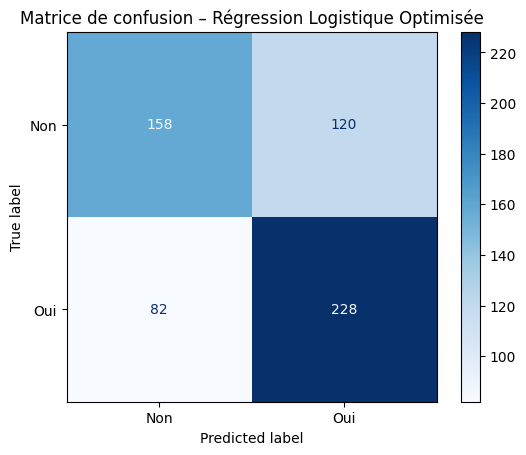

In [1003]:
# Matrice de confusion après optimisation
cm_log_optimized = confusion_matrix(y_test, log_pred)
disp_log_optimized = ConfusionMatrixDisplay(confusion_matrix=cm_log_optimized, display_labels=["Non", "Oui"])
disp_log_optimized.plot(cmap="Blues")
plt.title("Matrice de confusion – Régression Logistique Optimisée")
plt.show()

**Observations** : 
- F1-score optimisé : 69.3% (vs 68.7% avant GridSearch)
- Amélioration modeste avec l'optimisation (+2.6% en F1-score)
- Bon recall pour la classe "Oui" : 74% (le modèle capture bien les répondants)
- Recall faible pour "Non" : 57% (beaucoup de faux positifs)
- En optimisant, on a *réduit les faux négatifs* et on les a passé en *vrais positifs*
- Les *faux positifs* n'ont pas bougé


**Interprétation** : 
Ce modèle est conservateur dans ses prédictions négatives mais efficace pour identifier les clients susceptibles de répondre (74% de recall). Pour une campagne marketing, cela signifie qu'il minimise le risque de rater des clients potentiels mais peut inclure des clients moins réactifs, ce qui augmente les coûts de campagne.


=== INTERPRÉTATION DES COEFFICIENTS ===


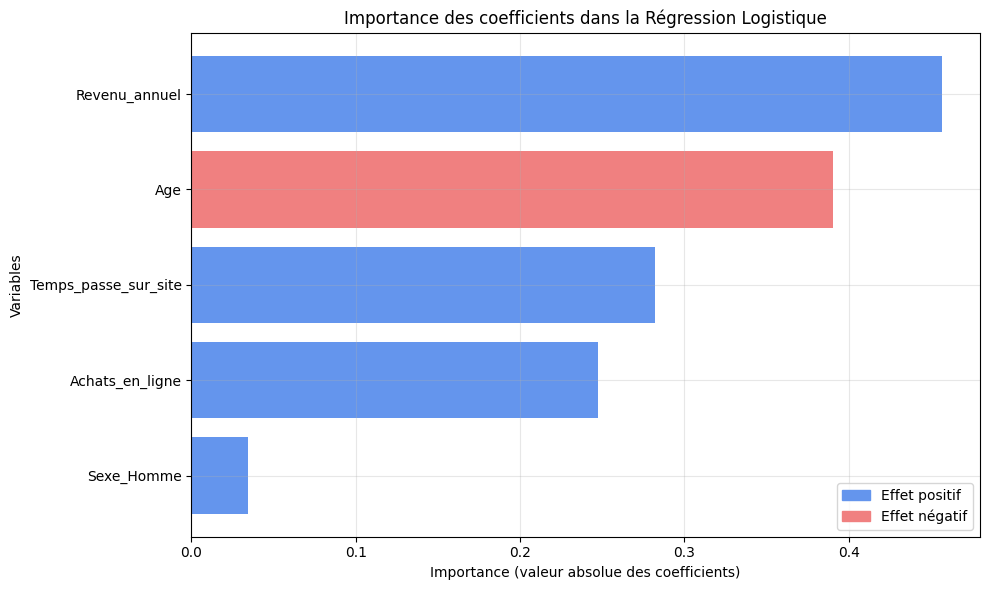

Importance des variables :
               Variable  Coefficient  Importance
1         Revenu_annuel     0.457026    0.457026
0                   Age    -0.390629    0.390629
2  Temps_passe_sur_site     0.282140    0.282140
3       Achats_en_ligne     0.247182    0.247182
4            Sexe_Homme     0.034705    0.034705

=== VALIDATION DES INSIGHTS PCA ===
Les variables les plus importantes selon la régression logistique :
- Revenu_annuel: augmente la probabilité de réponse (coef: 0.457)
- Age: diminue la probabilité de réponse (coef: -0.391)
- Temps_passe_sur_site: augmente la probabilité de réponse (coef: 0.282)


In [1004]:
print("\n=== INTERPRÉTATION DES COEFFICIENTS ===")
coefficients = best_log_model.coef_[0]
feature_names = problem_encoded.columns
coef_df = pd.DataFrame({'Variable': feature_names, 'Coefficient': coefficients})
coef_df['Importance'] = abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Importance', ascending=False)

# Graphique d'importance des coefficients
plt.figure(figsize=(10, 6))
top_features = coef_df.head(10)[::-1]  # Top 10 inversé pour l'affichage
colors = ['lightcoral' if coef < 0 else 'cornflowerblue' for coef in top_features['Coefficient']]

plt.barh(top_features["Variable"], top_features["Importance"], color=colors)
plt.title("Importance des coefficients dans la Régression Logistique")
plt.xlabel("Importance (valeur absolue des coefficients)")
plt.ylabel("Variables")
plt.grid(True, alpha=0.3)

# Légende
import matplotlib.patches as mpatches
pos_patch = mpatches.Patch(color='cornflowerblue', label='Effet positif')
neg_patch = mpatches.Patch(color='lightcoral', label='Effet négatif')
plt.legend(handles=[pos_patch, neg_patch])

plt.tight_layout()
plt.show()

print("Importance des variables :")
print(coef_df)

print("\n=== VALIDATION DES INSIGHTS PCA ===")
print("Les variables les plus importantes selon la régression logistique :")
for i, row in coef_df.head(3).iterrows():
    effet = "augmente" if row['Coefficient'] > 0 else "diminue"
    print(f"- {row['Variable']}: {effet} la probabilité de réponse (coef: {row['Coefficient']:.3f})")

#### **Analyse** : 

Le F1-score de 69% est correct mais perfectible, suggérant que ***les interactions complexes identifiées en PCA nécessitent peut-être des modèles plus sophistiqués (Random Forest/XGBoost)***. La régression logistique pourrait être limitée par la linéarité des relations dans nos segments très hétérogènes.

Les coefficients de la régression logistique confirment parfaitement nos découvertes exploratoires. Le **revenu annuel** émerge comme le facteur prédictif dominant (coefficient : 0.457), validant l'importance cruciale du pouvoir d'achat observée dans notre segmentation. **L'âge** se positionne en deuxième facteur avec un coefficient négatif de -0.391, confirmant mathématiquement que la probabilité de réponse diminue avec l'âge (donc moins on est vieux, plus on répond) et justifiant notre stratégie de ciblage prioritaire des très jeunes clients.

Le **temps passé sur site** occupe la troisième position (coefficient : 0.282). On voit se dresser un ***profil cohérent avec notre dimension PC_1 d'engagement commercial***. Il est notable que le **nombre d'achats passés** se classe seulement en quatrième position, suggérant que le potentiel économique (revenus et âge) prime sur l'historique d'achat. 

Remarquablement, **le sexe présente un impact quasi nul** (coefficient : 0.035), pourvant laisser penser que le genre n'est pas discriminant contrairement à nos observations segmentées où les femmes très jeunes surperforment - cette apparente contradiction pourrait s'expliquer par le fait que l'effet genre pourrait être concentré uniquement dans le segment ***des très jeunes aisés***.

En résumé :

- **Revenus + Âge** = facteurs de base pour identifier le potentiel
- **Achats + Temps** = facteurs de confirmation du comportement
- **Sexe ?** = oui peut-être, mais pour certains clusters particuliers

## 2. Arbre de décision (Decision Tree)

In [1005]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(x_train, y_train)
tree_pred = tree_model.predict(x_test)

print("\n Arbre de Décision")
print("F1-score :", f1_score(y_test, tree_pred))
print("Classification Report :\n", classification_report(y_test, tree_pred))


 Arbre de Décision
F1-score : 0.6169154228855721
Classification Report :
               precision    recall  f1-score   support

           0       0.58      0.62      0.60       278
           1       0.63      0.60      0.62       310

    accuracy                           0.61       588
   macro avg       0.61      0.61      0.61       588
weighted avg       0.61      0.61      0.61       588



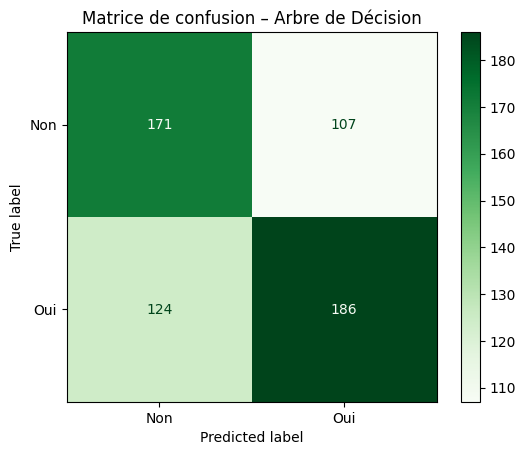

In [1006]:
cm_tree = confusion_matrix(y_test, tree_pred)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["Non", "Oui"])
disp_tree.plot(cmap="Greens")
plt.title("Matrice de confusion – Arbre de Décision")
plt.show()

In [1007]:
# Arbre de décision avec hyperparametres et gridsearch
tree_params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini']
}

tree_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    tree_params,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

tree_grid.fit(x_train, y_train)
best_tree_model = tree_grid.best_estimator_
tree_pred = best_tree_model.predict(x_test)

print("\n Arbre de Décision optimisé")
print("Meilleurs paramètres :", tree_grid.best_params_)
print("F1-score (validation croisée) :", tree_grid.best_score_)
print("F1-score (test set) :", f1_score(y_test, tree_pred))
print("\nClassification report :\n", classification_report(y_test, tree_pred))


 Arbre de Décision optimisé
Meilleurs paramètres : {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}
F1-score (validation croisée) : 0.7155282547326691
F1-score (test set) : 0.7174887892376681

Classification report :
               precision    recall  f1-score   support

           0       0.69      0.57      0.63       278
           1       0.67      0.77      0.72       310

    accuracy                           0.68       588
   macro avg       0.68      0.67      0.67       588
weighted avg       0.68      0.68      0.67       588



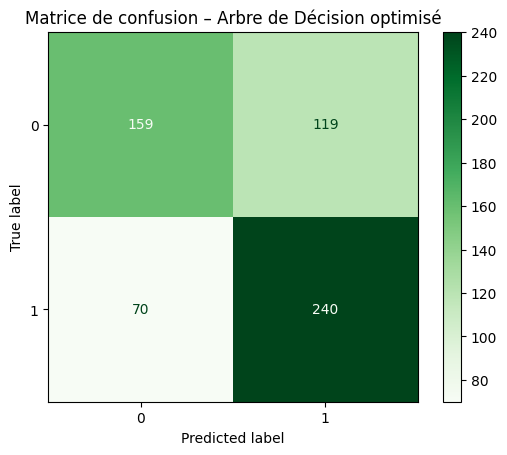

In [1008]:
# Matrice de confusion après optimisation
ConfusionMatrixDisplay.from_estimator(best_tree_model, x_test, y_test, cmap="Greens")
plt.title("Matrice de confusion – Arbre de Décision optimisé")
plt.show()

**Modèle de base (première matrice) :**

- Vrais Positifs : 186, Faux Négatifs : 124
- Vrais Négatifs : 171, Faux Positifs : 107
- Problème : beaucoup de faux négatifs (124)

**Modèle optimisé (seconde matrice) :**

- Vrais Positifs : 240, Faux Négatifs : 70
- Vrais Négatifs : 159, Faux Positifs : 119

**Amélioration** : -44% de faux négatifs, donc on a augmenté le recall (seulement pour la classe 1) et la précision générale, on a également optimisé le F1-Score (de .62 à .72)

#### Analyse :

L'optimisation des hyperparamètres a considérablement **amélioré les performances du modèle**. Le F1-score est passé de 0,62 à 0,72 (+16%), et la précision globale de 61% à 68% (+11%). Cette progression démontre l'importance cruciale du réglage des paramètres pour maximiser l'efficacité prédictive.

Le modèle optimisé a considérablement **réduit les faux négatifs** (de 124 à 70), diminuant de 44% le risque de passer à côté de clients intéressés. Cette amélioration est particulièrement précieuse dans un contexte commercial où chaque prospect manqué représente un manque à gagner.

**Amélioration du ciblage** : Le recall pour la classe positive (clients répondant) est passé de 60% à 77%, signifiant que le modèle identifie maintenant près de 8 prospects sur 10 au lieu de 6 sur 10 précédemment.

Le modèle optimisé présente un profil légèrement différent : il privilégie la détection des prospects (recall élevé à 77%) au détriment d'une précision plus modeste (67%), à travers une recherche d'**équilibre entre précision-rappel**. Cette orientation est généralement favorable dans le marketing, où il vaut mieux contacter quelques non-intéressés de plus plutôt que de manquer des prospects potentiels.

Les **paramètres optimaux** révèlent qu'un arbre de profondeur modérée (4 niveaux) avec une granularité fine (minimum 2 échantillons par division) offre le meilleur compromis. Cette configuration évite le surapprentissage tout en conservant suffisamment de complexité pour capturer les patterns pertinents dans les données.
Cette amélioration substantielle valide l'approche d'optimisation et fournit un modèle robuste pour l'identification des prospects.

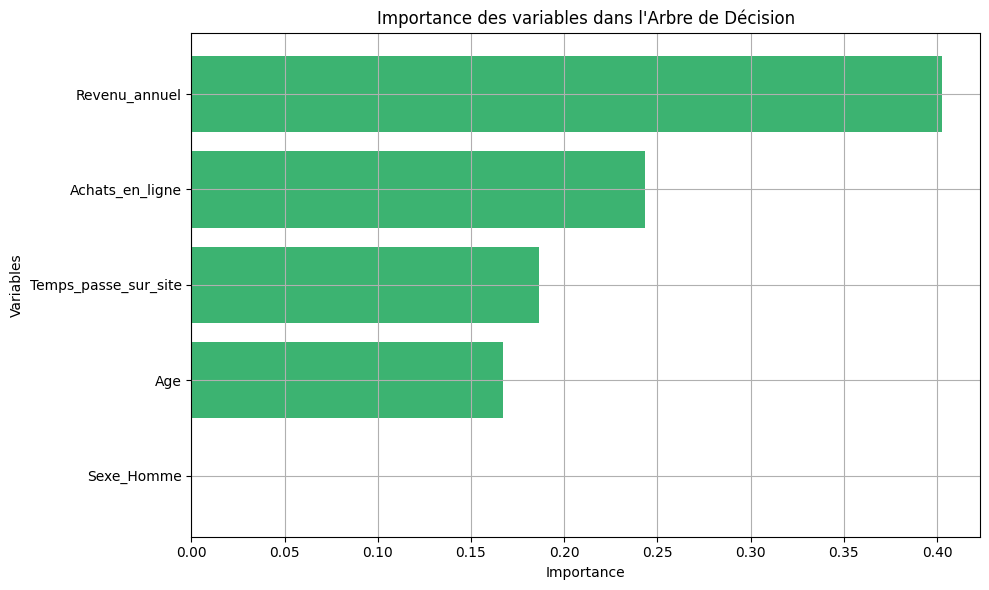

In [1014]:
# Récupérer les noms des colonnes
feature_names = problem_encoded.columns.tolist()  

# Récupérer l'importance des features
importances = best_tree_model.feature_importances_

# Créer un DataFrame pour trier et afficher
feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"][:10][::-1], feat_imp_df["Importance"][:10][::-1], color="mediumseagreen")
plt.title("Importance des variables dans l'Arbre de Décision")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.grid(True)
plt.tight_layout()
plt.show()


### Analyse :

Hiérarchie claire des facteurs prédictifs : **Le revenu annuel** domine largement avec une importance de ~0,40, soit le double du second facteur. Les **achats en ligne (0,24)** et le **temps passé sur site (0,18)** forment un second groupe d'importance modérée, tandis que l'**âge (0,16)** a un impact plus limité.

Le genre n'est pas discriminant : La variable "Sexe_Homme" présente une importance quasi-nulle, indiquant que le genre n'influence pas significativement la réponse à la campagne marketing.

!!! Le fait que l'âge soit si peu discriminant va à l'encontre d'un certain nombre d'observations réalisées précédemment. Ici, on voit vraiment se dresser le profil de l'engagé commercial (//PC1) , ou celoui de la richesse (//PC3) , mais qui ne s'exprime pas exactement dans le sens des analyses globales post-PCA, ni dans le sens de nos observations pour la régression logistiques. Ces variables principales dans notre arbre de décision sont assez neuves, puisqu'il est vrai que nous observions une synergie entre revenus élevés + temps élevé + achats élevés, mais encore davantage lorsque la personne était jeune. Ce qui comptait en priorité : Jeune, Bons revenus - les achats élevés dans certains cas, et le temps passé (qu'il soit fort ou faible) mais dans certains cas précis (fort parfois, faible parfois).

***Il se pourrait donc que le modèle ait répéré l'élément principal (le revenu), et qu'il ait aussi réussi à distinguer à quel moment le temps va compter, le revenu va compter, et l'âge va compter, selon des combinaisons dans des cas spécifiques.***

In [1017]:
print("=== RANDOM FOREST - MODÈLE DE BASE ===")

# 1. CRÉER LE MODÈLE DE BASE
# n_estimators = nombre d'arbres dans la forêt (par défaut: 100)
# random_state = pour la reproductibilité
rf_model = RandomForestClassifier(random_state=42)

# 2. ENTRAÎNER LE MODÈLE
rf_model.fit(x_train, y_train)

# 3. FAIRE DES PRÉDICTIONS
rf_pred = rf_model.predict(x_test)

# 4. ÉVALUER LES PERFORMANCES
print("Random Forest (modèle de base)")
print("F1-score :", f1_score(y_test, rf_pred))
print("Classification Report :\n", classification_report(y_test, rf_pred))


=== RANDOM FOREST - MODÈLE DE BASE ===
Random Forest (modèle de base)
F1-score : 0.678125
Classification Report :
               precision    recall  f1-score   support

           0       0.64      0.59      0.62       278
           1       0.66      0.70      0.68       310

    accuracy                           0.65       588
   macro avg       0.65      0.65      0.65       588
weighted avg       0.65      0.65      0.65       588



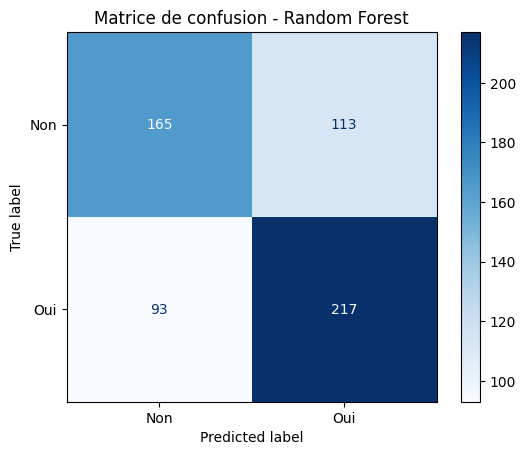

In [1019]:
# 5. MATRICE DE CONFUSION
from sklearn.metrics import ConfusionMatrixDisplay
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Non", "Oui"])
disp_rf.plot(cmap="Blues")
plt.title("Matrice de confusion - Random Forest")
plt.show()


In [1020]:
print("\n" + "="*50)
print("=== RANDOM FOREST - VERSION OPTIMISÉE ===")

# 6. OPTIMISATION AVEC GRID SEARCH
# Définir les paramètres à tester
rf_params = {
    'n_estimators': [50, 100, 200],           # Nombre d'arbres
    'max_depth': [3, 5, 7, None],             # Profondeur maximale
    'min_samples_split': [2, 5, 10],          # Échantillons min pour diviser
    'min_samples_leaf': [1, 2, 4]             # Échantillons min par feuille
}

# 7. GRID SEARCH AVEC VALIDATION CROISÉE
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,                    # 5-fold cross validation
    scoring='f1',            # Optimiser selon le F1-score
    n_jobs=-1,              # Utiliser tous les processeurs
    verbose=1               # Afficher le progrès
)

print("Entraînement du Random Forest optimisé...")
rf_grid.fit(x_train, y_train)

# 8. RÉCUPÉRER LE MEILLEUR MODÈLE
best_rf_model = rf_grid.best_estimator_
rf_pred_optimized = best_rf_model.predict(x_test)

# 9. RÉSULTATS OPTIMISÉS
print("\nRandom Forest optimisé")
print("Meilleurs paramètres :", rf_grid.best_params_)
print("Meilleur score CV :", rf_grid.best_score_)
print("F1-score (test set) :", f1_score(y_test, rf_pred_optimized))
print("\nClassification report :\n", classification_report(y_test, rf_pred_optimized))


=== RANDOM FOREST - VERSION OPTIMISÉE ===
Entraînement du Random Forest optimisé...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Random Forest optimisé
Meilleurs paramètres : {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Meilleur score CV : 0.7076929002293422
F1-score (test set) : 0.7099697885196374

Classification report :
               precision    recall  f1-score   support

           0       0.68      0.58      0.63       278
           1       0.67      0.76      0.71       310

    accuracy                           0.67       588
   macro avg       0.67      0.67      0.67       588
weighted avg       0.67      0.67      0.67       588



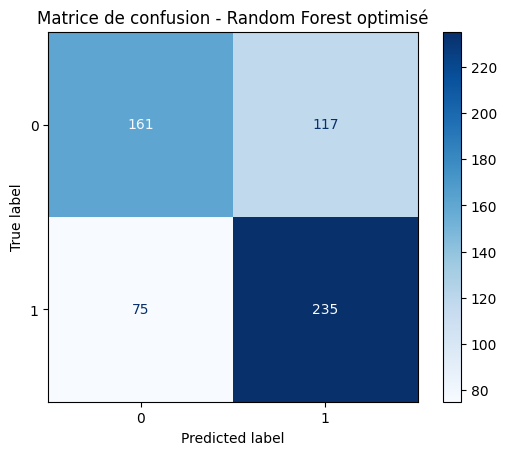

In [1022]:
# 10. MATRICE DE CONFUSION OPTIMISÉE
ConfusionMatrixDisplay.from_estimator(best_rf_model, x_test, y_test, cmap="Blues")
plt.title("Matrice de confusion - Random Forest optimisé")
plt.show()


=== IMPORTANCE DES VARIABLES ===


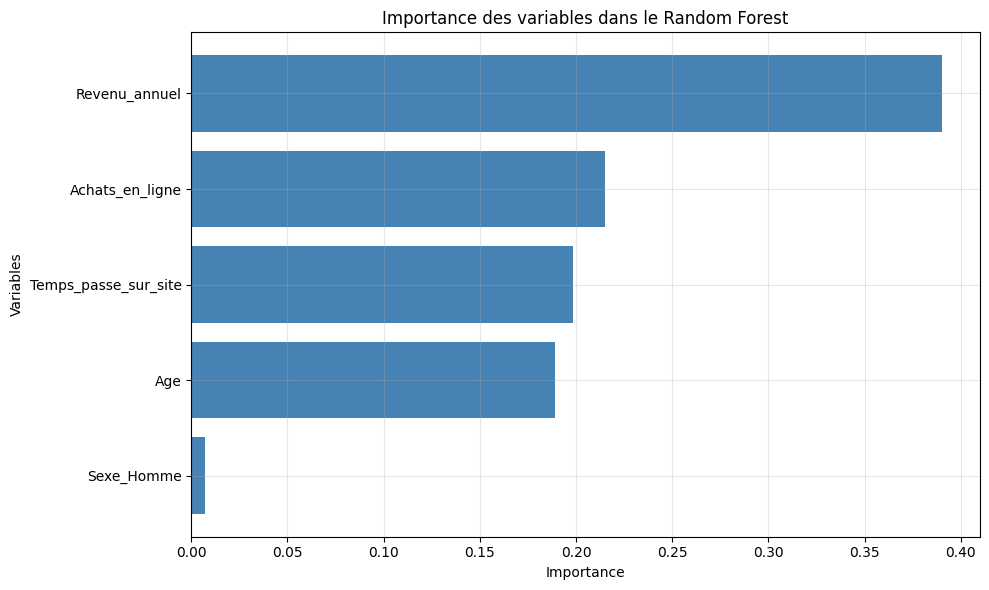

Top 10 des variables les plus importantes :
                Feature  Importance
1         Revenu_annuel    0.390438
3       Achats_en_ligne    0.215265
2  Temps_passe_sur_site    0.198611
0                   Age    0.188811
4            Sexe_Homme    0.006875


In [1024]:
print("\n" + "="*50)
print("=== IMPORTANCE DES VARIABLES ===")

# 11. ANALYSER L'IMPORTANCE DES VARIABLES
importances_rf = best_rf_model.feature_importances_

# Créer un DataFrame pour l'importance
rf_importance_df = pd.DataFrame({
    "Feature": problem_encoded.columns,  # Utiliser les vrais noms
    "Importance": importances_rf
}).sort_values(by="Importance", ascending=False)

# 12. GRAPHIQUE D'IMPORTANCE
plt.figure(figsize=(10, 6))
plt.barh(rf_importance_df["Feature"][:10][::-1], 
         rf_importance_df["Importance"][:10][::-1], 
         color="steelblue")
plt.title("Importance des variables dans le Random Forest")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 13. AFFICHER LE TOP 10
print("Top 10 des variables les plus importantes :")
print(rf_importance_df.head(10))


In [1025]:

print("\n" + "="*50)
print("=== COMPARAISON DES PERFORMANCES ===")

# 14. COMPARAISON FINALE
print("COMPARAISON :")
print(f"Random Forest de base    : F1-score = {f1_score(y_test, rf_pred):.3f}")
print(f"Random Forest optimisé   : F1-score = {f1_score(y_test, rf_pred_optimized):.3f}")

# Calculer l'amélioration
improvement = (f1_score(y_test, rf_pred_optimized) - f1_score(y_test, rf_pred)) / f1_score(y_test, rf_pred) * 100
print(f"Amélioration             : +{improvement:.1f}%")


=== COMPARAISON DES PERFORMANCES ===
COMPARAISON :
Random Forest de base    : F1-score = 0.678
Random Forest optimisé   : F1-score = 0.710
Amélioration             : +4.7%


## **4. Validation**